<a href="https://colab.research.google.com/github/akm2208/Aayushi-First-Files/blob/main/extremevaluedistribution_urban_non_urban_cive_5363.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/OpenHydrology/lmoments3.git
!pip install cftime
!pip install netCDF4

  Cloning https://github.com/OpenHydrology/lmoments3.git to /tmp/pip-req-build-wjrduij5
  Running command git clone --filter=blob:none --quiet https://github.com/OpenHydrology/lmoments3.git /tmp/pip-req-build-wjrduij5
  Resolved https://github.com/OpenHydrology/lmoments3.git to commit 7e19f97c23019ca68cbd526b8bd417c412438f1c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 16.4 MB/s eta 0:00:00


In [ ]:
import lmoments3 as lm
from lmoments3 import distr
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import glob
import os
import cftime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Historical Precipitation


In [ ]:
fn = "/content/drive/My Drive/CIVE5363_2023/pr_day_CanESM5_historical_r1i1p1f1_gn_18500101-20141231.nc"
ds =xr.open_dataset(fn, engine="netcdf4")
print(ds)

<xarray.Dataset>
Dimensions:    (time: 60225, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/76d65850-67a9-4ab7-92d2-0e63ed9...

In [ ]:
ds['lon'] = xr.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
ds = ds.sortby('lon')
print(ds)
lat=ds.lat.values
lon=ds.lon.values


<xarray.Dataset>
Dimensions:    (time: 60225, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 -177.2 -174.4 -171.6 -168.8 ... 174.4 177.2 180.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/76d65850-67a9-4ab7-92d2-0e63ed9...

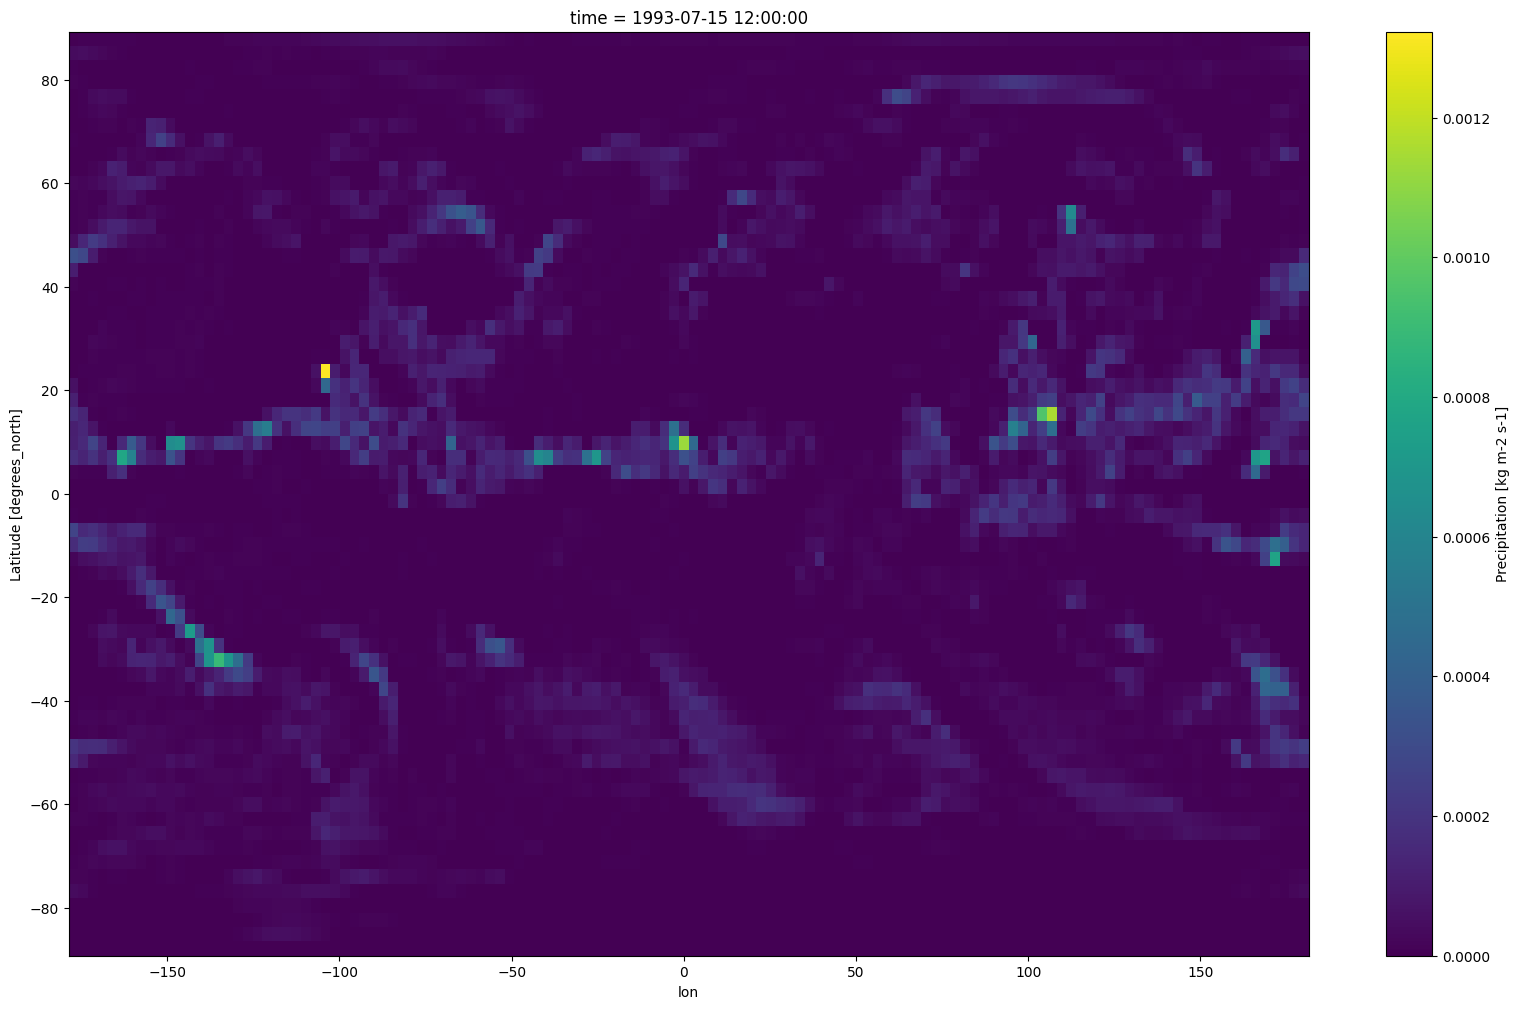

In [ ]:
pr = ds.sel(time = '1993-07-15')
plt.figure(figsize= [20,12])
pr['pr'].plot()

In [ ]:
def gev_wrapper(data,T):
    gevfit = gev_fit(data)
    RL = return_levels(gevfit,T)

    return  RL


def gev_fit(data):

    gevfit = distr.gev.lmom_fit(data)
    return gevfit


def return_levels(gevfit,T):

    #Return Level
    RL = distr.gev.ppf(1.0-1./T, **gevfit)

    return RL


In [ ]:
#urban area
latitude= 42.3601
longitude= -71.0589

sq_diff_lat = (lat - latitude)**2
sq_diff_lon = (lon - longitude)**2

#Identify the index of the min value for lat and lon
min_index_lat = sq_diff_lat.argmin()
min_index_lon = sq_diff_lon.argmin()
latitude_grid= lat.__getitem__(min_index_lat)
longitude_grid=lon.__getitem__(min_index_lon)

dsloc= ds.sel(lat=latitude_grid,lon= longitude_grid, method='nearest')
annual_max_urban = dsloc.groupby('time.year').max('time')

In [ ]:
annual_max_urban

<xarray.Dataset>
Dimensions:    (year: 165, bnds: 2)
Coordinates:
    lat        float64 43.25
    lon        float64 -70.31
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (year, bnds) object 1850-12-31 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (year, bnds) float64 41.86 44.66 41.86 ... 44.66 41.86 44.66
    lon_bnds   (year, bnds) float64 288.3 291.1 288.3 ... 291.1 288.3 291.1
    pr         (year) float32 0.0008187 0.0007944 ... 0.001023 0.0007885
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/76d65850-67a9-4ab7-92d2-0e63ed9...
    variable_id:                 pr
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

In [ ]:
#Rural area
latitude= 42.46
longitude= -73.00

sq_diff_lat = (lat - latitude)**2
sq_diff_lon = (lon - longitude)**2

#Identify the index of the min value for lat and lon
min_index_lat = sq_diff_lat.argmin()
min_index_lon = sq_diff_lon.argmin()
latitude_grid= lat.__getitem__(min_index_lat)
longitude_grid=lon.__getitem__(min_index_lon)

dsloc= ds.sel(lat=latitude_grid,lon= longitude_grid, method='nearest')
annual_max_rural = dsloc.groupby('time.year').max('time')

In [ ]:
annual_max_rural

<xarray.Dataset>
Dimensions:    (year: 165, bnds: 2)
Coordinates:
    lat        float64 43.25
    lon        float64 -73.12
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (year, bnds) object 1850-12-31 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (year, bnds) float64 41.86 44.66 41.86 ... 44.66 41.86 44.66
    lon_bnds   (year, bnds) float64 285.5 288.3 285.5 ... 288.3 285.5 288.3
    pr         (year) float32 0.00077 0.0004954 0.000763 ... 0.0007359 0.001122
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/76d65850-67a9-4ab7-92d2-0e63ed9...
    variable_id:                 pr
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

In [ ]:
if not np.isnan(np.min(annual_max_urban.pr)):
    annual_max_urban=np.array(annual_max_urban.pr)
if not np.isnan(np.min(annual_max_rural.pr)):
    annual_max_rural=np.array(annual_max_rural.pr)

In [ ]:
T_100  = np.arange(0.1, 99.1, 0.1) + 1
Urban_RL=  gev_wrapper(annual_max_urban,T_100)*86400
Rural_RL=  gev_wrapper(annual_max_rural,T_100)*86400


30 year Return Level for Urban Area =  105.08484031516393 mm/day
100 year Return Level  for Urban Area=  119.5032317274678 mm/day
30 year Return Level for Rural Area =  107.2352093482212 mm/day
100 year Return Level  for Rural Area=  124.7548736959072 mm/day


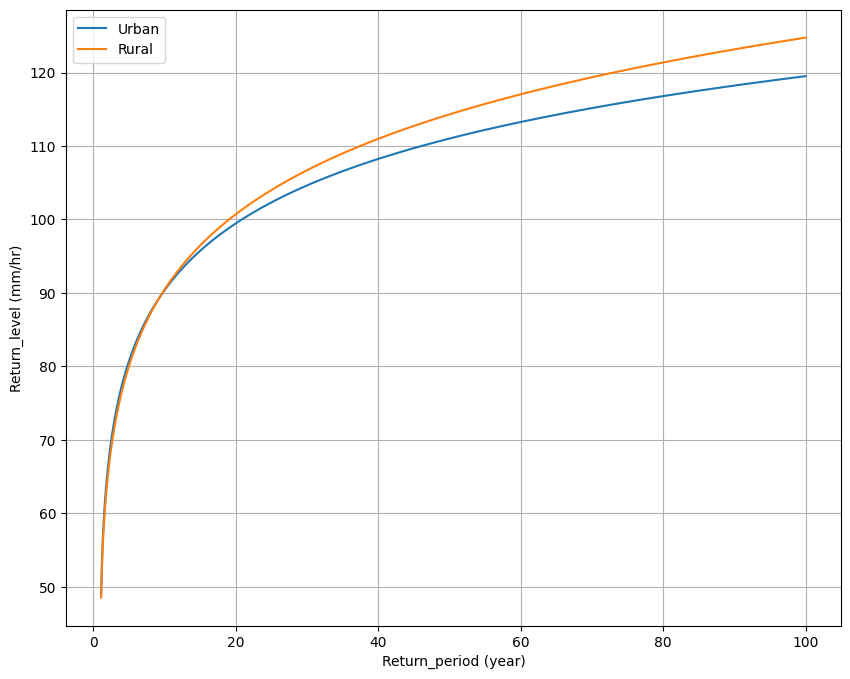

In [ ]:
Urban_RL_30= Urban_RL[300]
Urban_RL_100= Urban_RL[-1]

Rural_RL_30= Rural_RL[300]
Rural_RL_100= Rural_RL[-1]
print(f"30 year Return Level for Urban Area =  {Urban_RL_30} mm/day")
print(f"100 year Return Level  for Urban Area=  {Urban_RL_100} mm/day")

print(f"30 year Return Level for Rural Area =  {Rural_RL_30} mm/day")
print(f"100 year Return Level  for Rural Area=  {Rural_RL_100} mm/day")

plt.figure(figsize=[10,8])
plt.plot(T_100,Urban_RL,label='Urban')
plt.plot(T_100,Rural_RL,label='Rural')
plt.grid()
plt.ylabel('Return_level (mm/day)')
plt.xlabel('Return_period (year)')
plt.legend()

In [ ]:
PEVI_Urban= Urban_RL_100/Urban_RL_30
print(f"PEVI_Urban= {PEVI_Urban}")
PEVI_Rural= Rural_RL_100/Rural_RL_30
print(f"PEVI_Rural= {PEVI_Rural}")

PEVI_Urban= 1.1372071496617508
PEVI_Rural= 1.163376044623506


Climate Model precipitation


In [ ]:
fn = "/content/drive/My Drive/CIVE5363_2023/pr_day_CanESM5_ssp585_r11i1p1f1_gn_20150101-21001231.nc"
ds =xr.open_dataset(fn, engine="netcdf4")
print(ds)

<xarray.Dataset>
Dimensions:    (time: 31390, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          rc3.1-his11
    CCCma_pycmor_hash:           26c970628162d607fffd14254956ebc6dd3b6f49
    CCCma_runid:                 rc3.1-s8511
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/8af46aaf-250e-4f47-9721-e4b0136...
    variable_id:               

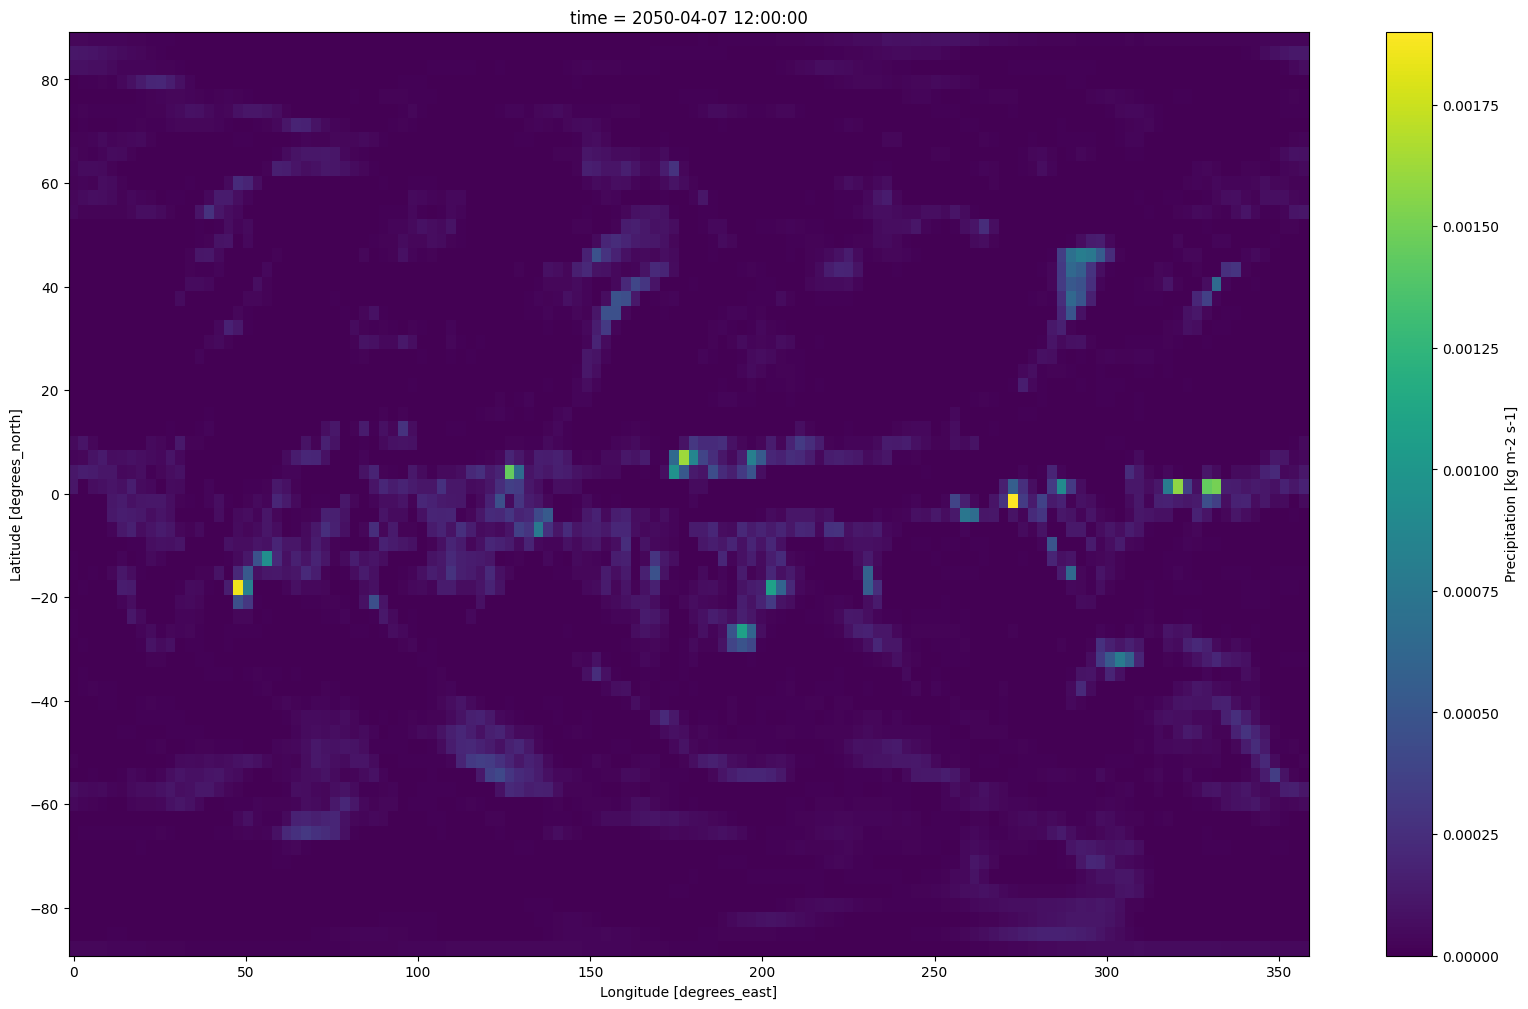

In [ ]:
pr = ds.sel(time = '2050-04-07')
plt.figure(figsize=[20,12])
pr['pr'].plot()


In [ ]:
ds['lon'] = xr.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
ds = ds.sortby('lon')
lat=ds.lat.values
lon=ds.lon.values
#urban area
latitude= 42.3601
longitude= -71.0589

sq_diff_lat = (lat - latitude)**2
sq_diff_lon = (lon - longitude)**2

#Identify the index of the min value for lat and lon
min_index_lat = sq_diff_lat.argmin()
min_index_lon = sq_diff_lon.argmin()
latitude_grid= lat.__getitem__(min_index_lat)
longitude_grid=lon.__getitem__(min_index_lon)

dsloc= ds.sel(lat=latitude_grid,lon= longitude_grid, method='nearest')
annual_max_urban = dsloc.groupby('time.year').max('time')
#rural area
latitude= 42.46
longitude= -73.00

sq_diff_lat = (lat - latitude)**2
sq_diff_lon = (lon - longitude)**2

#Identify the index of the min value for lat and lon
min_index_lat = sq_diff_lat.argmin()
min_index_lon = sq_diff_lon.argmin()
latitude_grid= lat.__getitem__(min_index_lat)
longitude_grid=lon.__getitem__(min_index_lon)

dsloc= ds.sel(lat=latitude_grid,lon= longitude_grid, method='nearest')
annual_max_rural = dsloc.groupby('time.year').max('time')

if not np.isnan(np.min(annual_max_urban.pr)):
    annual_max_urban=np.array(annual_max_urban.pr)
if not np.isnan(np.min(annual_max_rural.pr)):
    annual_max_rural=np.array(annual_max_rural.pr)

T_100  = np.arange(0.1, 99.1, 0.1) + 1
Future_Urban_RL=  gev_wrapper(annual_max_urban,T_100)*86400
Future_Rural_RL=  gev_wrapper(annual_max_rural,T_100)*86400


30 year Return Level for Urban Area =  149.95729653338884 mm/day
100 year Return Level  for Urban Area=  174.10109711509773 mm/day
30 year Return Level for Rural Area =  135.60296618380923 mm/day
100 year Return Level  for Rural Area=  163.88021120662785 mm/day
PEVI_Urban= 1.161004506881952
PEVI_Rural= 1.208529693845258


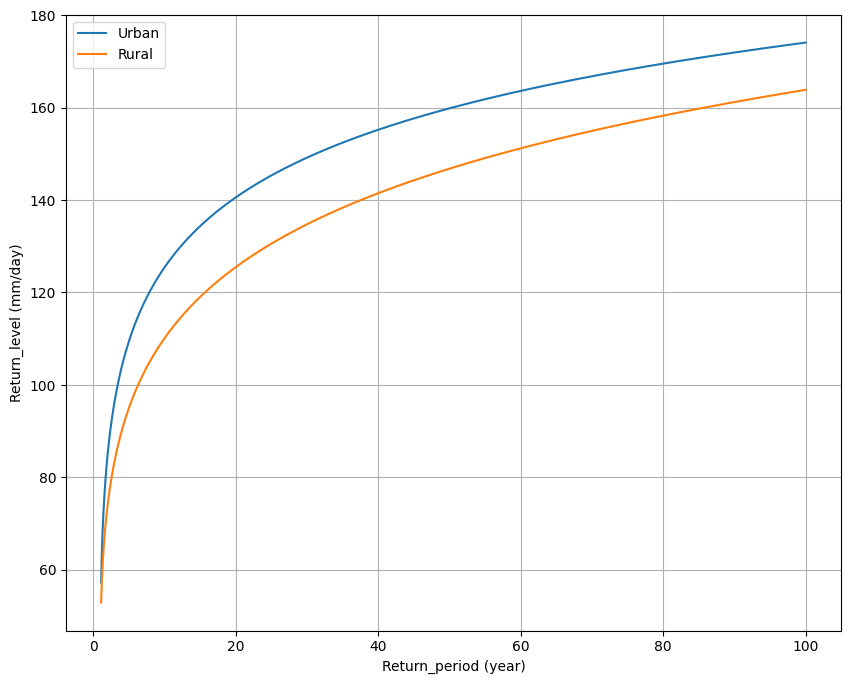

In [ ]:
Future_Urban_RL_30= Future_Urban_RL[300]
Future_Urban_RL_100= Future_Urban_RL[-1]

Future_Rural_RL_30= Future_Rural_RL[300]
Future_Rural_RL_100= Future_Rural_RL[-1]
print(f"30 year Return Level for Urban Area =  {Future_Urban_RL_30} mm/day")
print(f"100 year Return Level  for Urban Area=  {Future_Urban_RL_100} mm/day")

print(f"30 year Return Level for Rural Area =  {Future_Rural_RL_30} mm/day")
print(f"100 year Return Level  for Rural Area=  {Future_Rural_RL_100} mm/day")

plt.figure(figsize=[10,8])
plt.plot(T_100,Future_Urban_RL,label='Urban')
plt.plot(T_100,Future_Rural_RL,label='Rural')
plt.grid()
plt.ylabel('Return_level (mm/day)')
plt.xlabel('Return_period (year)')
plt.legend()

PEVI_Urban= Future_Urban_RL_100/Future_Urban_RL_30
print(f"PEVI_Urban= {PEVI_Urban}")
PEVI_Rural= Future_Rural_RL_100/Future_Rural_RL_30
print(f"PEVI_Rural= {PEVI_Rural}")

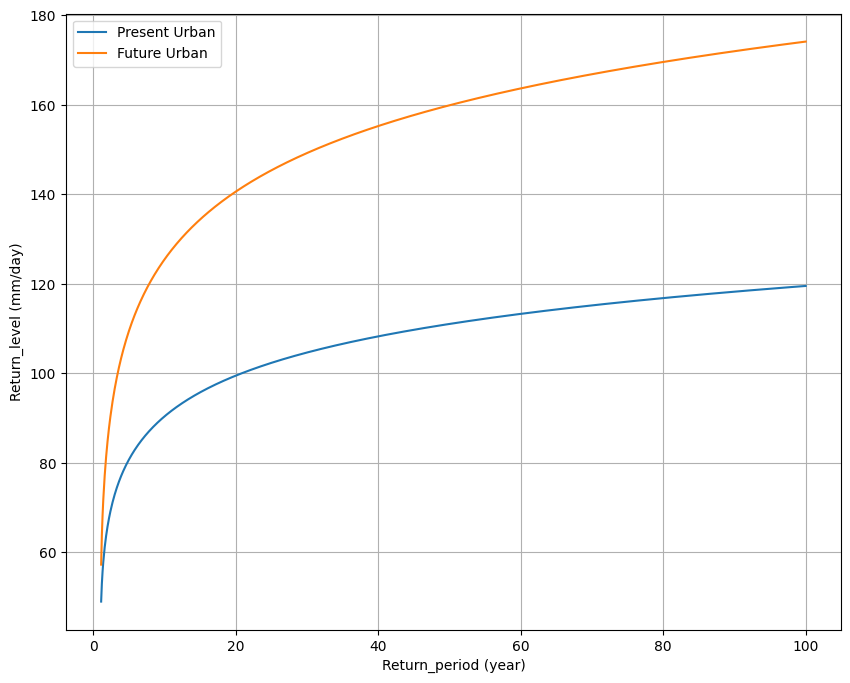

In [ ]:

plt.figure(figsize=[10,8])
plt.plot(T_100,Urban_RL,label='Present Urban')
plt.plot(T_100,Future_Urban_RL,label='Future Urban')
plt.grid()
plt.ylabel('Return_level (mm/day)')
plt.xlabel('Return_period (year)')
plt.legend()

Population Grid

In [ ]:
file_pop= "/content/drive/My Drive/CIVE5363_2023/gpw_v4_population_count_rev11_15_min.nc"
ds_pop =xr.open_dataset(file_pop)

In [ ]:
print(ds_pop)
print(ds_pop.variables)

<xarray.Dataset>
Dimensions:                                                                 (
                                                                             longitude: 1440,
                                                                             latitude: 720,
                                                                             raster: 20)
Coordinates:
  * longitude                                                               (longitude) float64 ...
  * latitude                                                                (latitude) float64 ...
  * raster                                                                  (raster) int32 ...
Data variables:
    Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes  (raster, latitude, longitude) float32 ...
Attributes:
    proj4:        +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0...
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 2.8-4)
    date

In [ ]:
lat=ds_pop.latitude.values
lon=ds_pop.longitude.values
latitude= 42.3601
longitude= -71.0589

sq_diff_lat = (lat - latitude)**2
sq_diff_lon = (lon - longitude)**2

#Identify the index of the min value for lat and lon
min_index_lat = sq_diff_lat.argmin()
min_index_lon = sq_diff_lon.argmin()
latitude_grid= lat.__getitem__(min_index_lat)
longitude_grid=lon.__getitem__(min_index_lon)

dsloc= ds_pop.sel(latitude=latitude_grid,longitude= longitude_grid,raster=5, method='nearest')

pop_urban=dsloc['Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes'].values
print(pop_urban)

1621281.8


In [ ]:
lat=ds_pop.latitude.values
lon=ds_pop.longitude.values
latitude= 42.46
longitude= -73.00


sq_diff_lat = (lat - latitude)**2
sq_diff_lon = (lon - longitude)**2

#Identify the index of the min value for lat and lon
min_index_lat = sq_diff_lat.argmin()
min_index_lon = sq_diff_lon.argmin()
latitude_grid= lat.__getitem__(min_index_lat)
longitude_grid=lon.__getitem__(min_index_lon)

dsloc= ds_pop.sel(latitude=latitude_grid,longitude= longitude_grid,raster=5, method='nearest')

pop_rural=dsloc['Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes'].values
print(pop_rural)

40579.504


In [ ]:
urban_pop_index= (1621281.75-40579.504)/1621281.75
urban_pop_index

0.9749707267105178

In [ ]:
risk_in_urban_area =urban_pop_index* PEVI_Urban
risk_in_urban_area

1.1319454077888829